In [1]:
pwd()

'/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/python'

In [71]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [4]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io

In [5]:
data_dir = '../../../data/'

In [6]:
data = pd.read_csv('../../../data/nsddata/ppdata/subj05/behav/responses.tsv', sep='\t')

In [8]:
data

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,5,1,1,1,46003,626,0.702211,0,1.0,1410.094287,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,5,1,1,2,5737,5013,0.702257,0,1.0,497.392116,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,5,1,1,3,9204,4850,0.702303,0,1.0,602.587655,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,5,1,1,4,33363,8823,0.702350,0,1.0,432.513789,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,5,1,1,5,64487,9538,0.702396,0,1.0,552.897393,0.0,NaN,NaN,0,1.0,1,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,5,40,12,58,46529,8984,281.794173,1,1.0,1903.628282,0.0,20963.0,21540.0,0,0.0,0,1,2.0,0
29996,5,40,12,59,50684,6026,281.794219,1,1.0,531.718771,0.0,16.0,17622.0,1,1.0,0,1,2.0,0
29997,5,40,12,60,44063,4841,281.794266,1,0.0,1417.057453,0.0,9483.0,11912.0,0,1.0,1,0,1.0,0
29998,5,40,12,61,53238,7323,281.794312,1,1.0,661.560379,0.0,83.0,12162.0,1,1.0,0,1,2.0,0


In [7]:
expdesign = scipy.io.loadmat(data_dir+'nsddata/experiments/nsd/nsd_expdesign.mat')
sharedix = expdesign['sharedix']

In [9]:
all_ids = np.array(data['73KID'])

In [13]:
mask = np.isin(all_ids,sharedix)
mask.shape

(30000,)

In [22]:
id_nums = all_ids[mask]
id_nums

array([46003, 48618, 44981, ..., 12496, 41779, 20224])

In [24]:
for s in range(1,41):
    if(s < 10):
        idx = '0' + str(s)
    else:
        idx = str(s)
            
    raw_betas = h5py.File(data_dir+'nsddata_betas/ppdata/subj05/nativesurface/betas_fithrf_GLMdenoise_RR/rh.betas_session'+idx+'.hdf5', 'r')
    betas = raw_betas['betas'][:]/300
    
    sess_shared_betas = betas[mask[(s-1)*750:s*750]]
    
    if(s==1):
        shared_betas = sess_shared_betas
    else:
        shared_betas = np.concatenate((shared_betas, sess_shared_betas))

In [25]:
shared_betas.shape

(3000, 198908)

In [26]:
mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj05/label/rh.streams.mgz')
rh_streams = mgh_file.get_fdata()

In [67]:
rh_streams.shape
rh_streams = rh_streams[:,0,0] #trim

(198908,)

In [284]:
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

In [34]:
vals, idx_start, count = np.unique(id_nums, return_counts=True,
                                return_index=True)
#we'll need count for subjects where not all 3 repeats

In [43]:
arr1inds = id_nums.argsort()
sorted_id_nums = id_nums[arr1inds[::-1]]
sorted_shared_betas = shared_betas[arr1inds[::-1]]

array([2750,  914,  234, 2765, 1804, 1823,  601,  590,  621,  428])

In [49]:
sorted_shared_betas.shape

(3000, 198908)

In [53]:

first_beta = sorted_shared_betas[0::3]
second_beta = sorted_shared_betas[1::3]
third_beta = sorted_shared_betas[2::3]

In [151]:
betas_by_repeat = np.zeros((1000,len(rh_streams),3))
for r in range(3):
    betas_by_repeat[:,:,r] = sorted_shared_betas[r::3]

In [152]:
betas_by_repeat.shape

(1000, 198908, 3)

In [153]:
#calculate split-half reliability
#3 possible combos (trial 1 vs mean 2 & 3; trial 2 vs mean 1 & 3; trial 3 vs mean 1 & 2)

repeat_mean = np.zeros((1000,len(rh_streams),3))
repeat_mean[:,:,0] = np.mean([betas_by_repeat[:,:,1],betas_by_repeat[:,:,2]],axis=0) #mean 2 & 3
repeat_mean[:,:,1] = np.mean([betas_by_repeat[:,:,0],betas_by_repeat[:,:,2]],axis=0) #mean 1 & 3
repeat_mean[:,:,2] = np.mean([betas_by_repeat[:,:,0],betas_by_repeat[:,:,1]],axis=0) #mean 1 & 2

corrvals = np.zeros((len(rh_streams),3))
for vox in range(len(rh_streams)):
    for r in range(3):
        corrval = stats.pearsonr(betas_by_repeat[:,vox,r], 
                                    repeat_mean[:,vox,r])[0]
        corrvals[vox, r] = corrval


In [155]:
avg_corrvals = np.mean(corrvals, axis=1)
avg_corrvals.shape

(198908,)

In [156]:
best = np.argmax(avg_corrvals)
print(np.max(avg_corrvals))

0.781054775385023


In [158]:
for r in range(8):
    print(np.mean(avg_corrvals[np.where(rh_streams == r)[0]]))

0.04522186406118474
0.2804688197017913
0.2910228255601533
0.28748662252919766
0.3023939356121129
0.15573758342428992
0.18207734067410145
0.1975059765726377


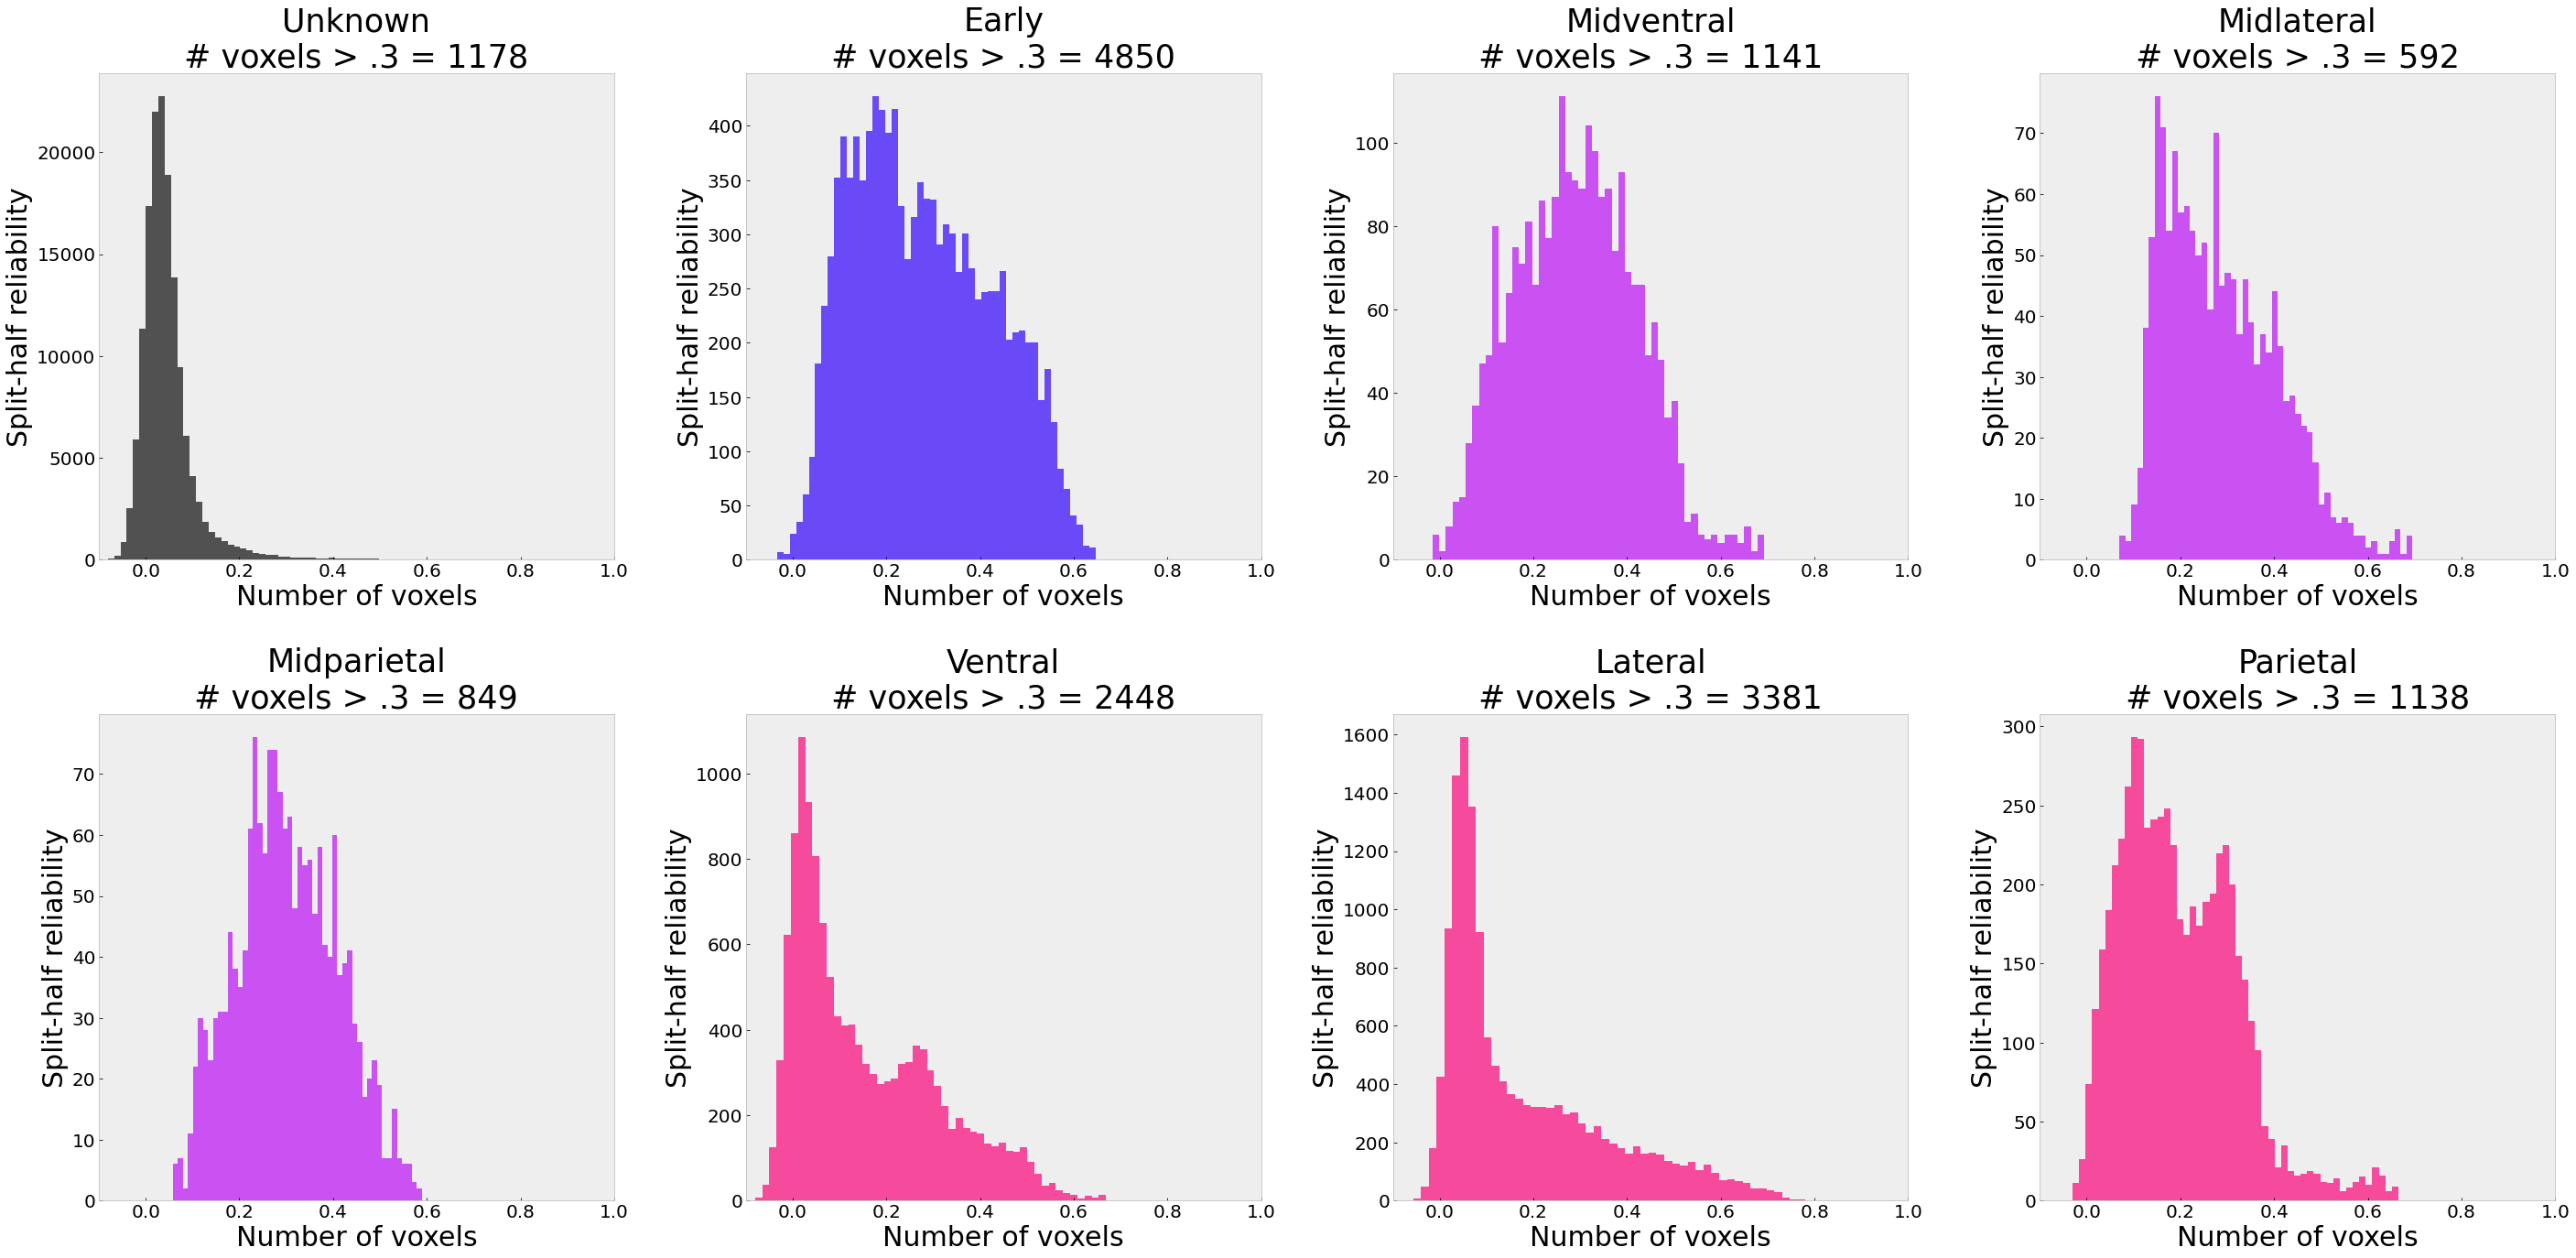

In [349]:
#plot histograms of avg split-half reliability (avg across the three combos) for voxels in each ROI (+ unknown)
c = ['#0f0f0f', '#3205fa', '#bc0ff5', '#bc0ff5', '#bc0ff5', '#fa057b', '#fa057b', '#fa057b']

plt.figure(figsize=(40, 20))
for r in range(8):
    plt.subplot(2, 4, r+1)
    
    n_vox = np.sum(avg_corrvals[np.where(rh_streams == r)[0]]>.3)
    
    plt.hist(avg_corrvals[np.where(rh_streams == r)[0]],bins=50,alpha=0.7, rwidth=1, color = c[r])
    
    plt.xlim(-0.1,1)
    plt.xticks(fontsize=20)
    
    #plt.xlim(-0.1,1)
    plt.yticks(fontsize=20)
    
    plt.xlabel('Number of voxels',size = 30)
    plt.ylabel('Split-half reliability',size = 30)
    
    title_string = ROI_names[r]
    title_string += "\n"
    title_string += r"# voxels > .3 = %d" % (n_vox)
    plt.title(title_string,size = 35)
    
    plt.style.use("bmh")
    plt.grid(False)
    
    plt.tight_layout(pad=4)


In [69]:
EVC_idx = np.where(rh_streams == 1)[0]
EVC_idx.shape

(11439,)

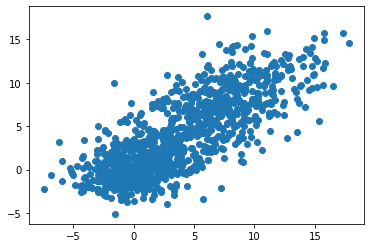

In [132]:
plt.scatter(first_beta[:,best], repeat_mean[:,best])

## RSMS

In [178]:
overall_mean_betas = np.mean(betas_by_repeat, axis=2)
overall_mean_betas.shape

(1000, 198908)

Text(0, 0.5, 'stimuli id')

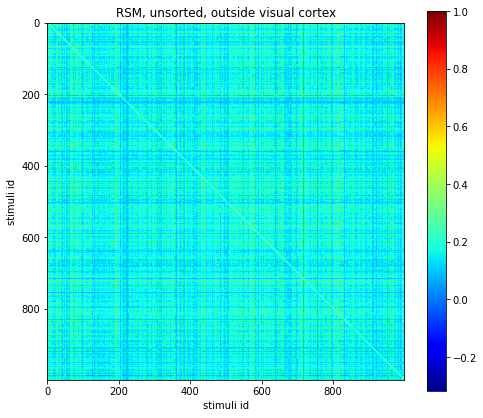

In [180]:
#SANITY CHECK - nothing really for non visual cortex voxels


# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

#plt.imshow(
#    np.corrcoef(betas_by_repeat[:,np.where(rh_streams == 0)[0],0]), 
#    cmap='jet', 
#)

plt.imshow(
    np.corrcoef(overall_mean_betas[:,np.where(rh_streams == 0)[0]]), 
    cmap='jet', 
)
plt.colorbar()
ax.set_title('RSM, unsorted, outside visual cortex')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')


Text(0, 0.5, 'stimuli id')

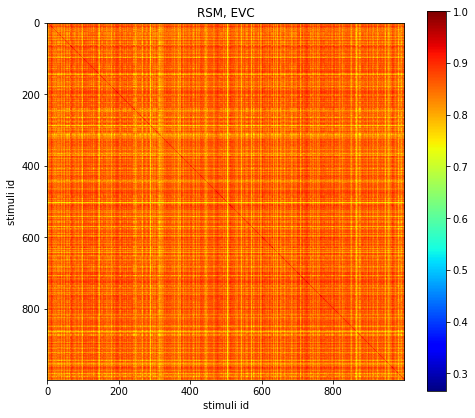

In [185]:
# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

#plt.imshow(
#    np.corrcoef(betas_by_repeat[:,np.where(rh_streams == 0)[0],0]), 
#    cmap='jet', 
#)

plt.imshow(
    np.corrcoef(overall_mean_betas[:,np.where(rh_streams == 1)[0]]), 
    cmap='jet', 
)
plt.colorbar()
ax.set_title('RSM, EVC')
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

In [223]:
# credit to https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

### THIS IS ACTUALLY EQUIVALENT TO (TESTED) 
#full = np.corrcoef(x,y)
#full[:1000,1000:]

(1000000, 3)


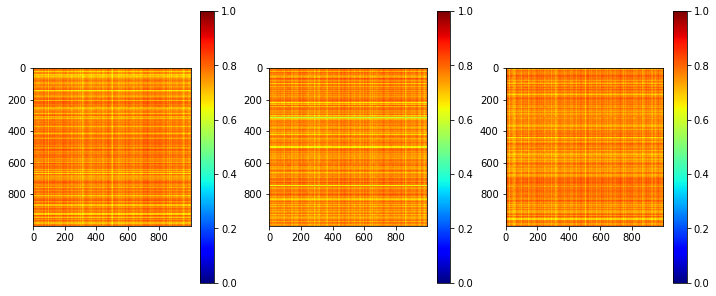

In [248]:
EVC_flat_rsm = np.zeros((1000*1000,3))
plt.figure(figsize=(12, 5))
for r in range(3):
    plt.subplot(1, 3, r+1)
    
    rsm = corr2_coeff(betas_by_repeat[:,EVC_idx,r], repeat_mean[:,EVC_idx,r])
    plt.imshow(
        rsm, 
        cmap='jet', 
    )
    plt.colorbar()
    plt.clim(0,1)
    
    lower = np.tril(rsm, -1).T.ravel()
    diag = np.diag(rsm)
    upper = np.triu(rsm, 1).T.ravel()

    EVC_flat_rsm[:,r] = np.concatenate([lower[lower != 0], diag, upper[upper != 0]])

print(EVC_flat_rsm.shape)


In [252]:
print(stats.pearsonr(EVC_flat_rsm[:,0],EVC_flat_rsm[:,1])[0])
print(stats.pearsonr(EVC_flat_rsm[:,0],EVC_flat_rsm[:,2])[0])
print(stats.pearsonr(EVC_flat_rsm[:,1],EVC_flat_rsm[:,2])[0])

0.23402516412932547
0.25103449146983625
0.24202415759246687


(1000000, 3)


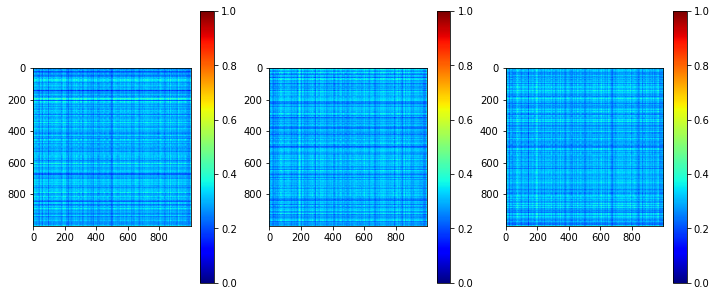

In [253]:
VTC_flat_rsm = np.zeros((1000*1000,3))
plt.figure(figsize=(12, 5))
for r in range(3):
    plt.subplot(1, 3, r+1)
    
    rsm = corr2_coeff(betas_by_repeat[:,rh_streams == 5,r], repeat_mean[:,rh_streams == 5,r])
    plt.imshow(
        rsm, 
        cmap='jet', 
    )
    plt.colorbar()
    plt.clim(0,1)
    
    lower = np.tril(rsm, -1).T.ravel()
    diag = np.diag(rsm)
    upper = np.triu(rsm, 1).T.ravel()

    VTC_flat_rsm[:,r] = np.concatenate([lower[lower != 0], diag, upper[upper != 0]])

print(VTC_flat_rsm.shape)


In [262]:
VTC_combos = [stats.pearsonr(VTC_flat_rsm[:,0],VTC_flat_rsm[:,1])[0],
              stats.pearsonr(VTC_flat_rsm[:,0],VTC_flat_rsm[:,2])[0],
              stats.pearsonr(VTC_flat_rsm[:,1],VTC_flat_rsm[:,2])[0]]
np.mean(VTC_combos)

0.30287087873103946

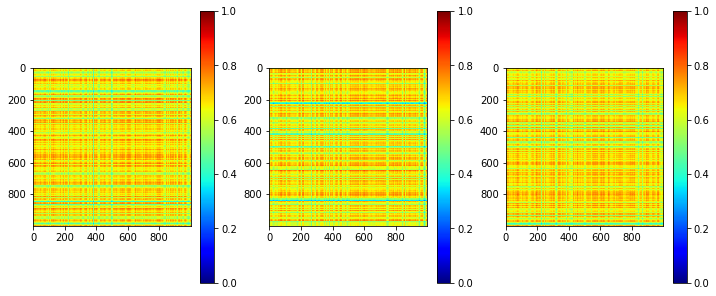

In [255]:
LOTC_flat_rsm = np.zeros((1000*1000,3))
plt.figure(figsize=(12, 5))
for r in range(3):
    plt.subplot(1, 3, r+1)
    
    rsm = corr2_coeff(betas_by_repeat[:,rh_streams == 7,r], repeat_mean[:,rh_streams == 7,r])
    plt.imshow(
        rsm, 
        cmap='jet', 
    )
    plt.colorbar()
    plt.clim(0,1)
    
    lower = np.tril(rsm, -1).T.ravel()
    diag = np.diag(rsm)
    upper = np.triu(rsm, 1).T.ravel()

    LOTC_flat_rsm[:,r] = np.concatenate([lower[lower != 0], diag, upper[upper != 0]])


In [264]:
LOTC_combos = [stats.pearsonr(LOTC_flat_rsm[:,0],LOTC_flat_rsm[:,1])[0],
              stats.pearsonr(LOTC_flat_rsm[:,0],LOTC_flat_rsm[:,2])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],LOTC_flat_rsm[:,2])[0]]
np.mean(LOTC_combos)


0.2685103360851128

In [260]:
all_combos = [stats.pearsonr(LOTC_flat_rsm[:,0],VTC_flat_rsm[:,0])[0],
              stats.pearsonr(LOTC_flat_rsm[:,0],VTC_flat_rsm[:,1])[0],
              stats.pearsonr(LOTC_flat_rsm[:,0],VTC_flat_rsm[:,2])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],VTC_flat_rsm[:,0])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],VTC_flat_rsm[:,1])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],VTC_flat_rsm[:,2])[0],
              stats.pearsonr(LOTC_flat_rsm[:,2],VTC_flat_rsm[:,0])[0],
              stats.pearsonr(LOTC_flat_rsm[:,2],VTC_flat_rsm[:,1])[0],
              stats.pearsonr(LOTC_flat_rsm[:,2],VTC_flat_rsm[:,2])[0]]
alt_combos = [stats.pearsonr(LOTC_flat_rsm[:,0],VTC_flat_rsm[:,1])[0],
              stats.pearsonr(LOTC_flat_rsm[:,0],VTC_flat_rsm[:,2])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],VTC_flat_rsm[:,0])[0],
              stats.pearsonr(LOTC_flat_rsm[:,1],VTC_flat_rsm[:,2])[0],
              stats.pearsonr(LOTC_flat_rsm[:,2],VTC_flat_rsm[:,0])[0],
              stats.pearsonr(LOTC_flat_rsm[:,2],VTC_flat_rsm[:,1])[0]]

In [350]:
print(all_combos)
#remove same trial comparison because that's unfair?

[0.6152366794494875, 0.1304383434172646, 0.2115029884463478, 0.16912100511487096, 0.609543228651928, 0.1901369246718108, 0.18826421226953938, 0.15803695615865135, 0.5952392950124273]


In [261]:
np.mean(alt_combos)

0.1745834050130808

In [266]:
print(stats.ttest_ind(alt_combos, VTC_combos))
print(stats.ttest_ind(alt_combos, LOTC_combos))

Ttest_indResult(statistic=-7.343866617432799, pvalue=0.0001567514790541206)
Ttest_indResult(statistic=-3.6078515588522797, pvalue=0.008648883415918206)
